In [1]:
# import relevant libraries

# import data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import utilities libraries
import itertools
import os
# import data consumption API
import quandl
# import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.offsets import *
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import deep learning libraries
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
# remove warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Some useful functions

In [2]:
#get the same index as the features vector for the target
def set_index(features, target):
    
    #remove the too many index at the end
    time_delta = int((features.index[-1] - target.index[-1]).days)
    target_bis = target[:time_delta]
    
    print('delta removed: '+ str(- time_delta))
    return target_bis

In [3]:
#define a function to split a correct train and test set
def split_train_test(features, target, history, horizon, verbose = True):
    
    #check the equality of the indexes of the features set and the target
    assert (features.index[0] == target.index[0]) & (features.index[-1] == target.index[-1])
    
    X_train = features[-(history):-horizon]
    y_train = target[-(history):-horizon]
    X_test = features[-horizon:]
    y_test = target[-horizon:]
    
    if verbose == True:
        print('Training set: ' + str(X_train.index[0]) + ' to ' + str(X_train.index[-1]) + ' ; Days:'+ str(len(X_train))+ '\n'
              ' Testing set: ' + str(X_test.index[0]) + ' to ' + str(X_test.index[-1]) + ' ; Days:'+ str(len(X_test)))

    return X_train, y_train, X_test, y_test
    

In [4]:
#define a function to find combinations of features
def features_combin(k):
    comb_k = {}
    comb_k = list(itertools.combinations(df_features.columns, k))
    return comb_k

In [5]:
#function to set the training and test with the right features
def set_features(df, features_list):
    train = df[features_list]
    return train

In [6]:
# define our rolling cross validation function
def rolling_prediction(model, train, target_train, test, target_test, verbose = 2):
    
    y_predict = []
    k =0
    
    for i in range(len(test)):
        
        k+=1
        
        #build a full df for rolling window
        X_full = train.append(test)
        y_full = target_train.append(target_test)
        
        #set X_full to the right features
        X_full = set_features(X_full, list(features[c]))
        
        #every predictions except the last:
        if k < len(test):
        
            # fit the model until i
            X_train_temp = X_full[:len(train)+i]
            y_train_temp = y_full[:len(target_train)+i]
            

            if verbose >= 2:
                print('TRAIN:', X_train_temp.index)

            model.fit(X_train_temp, y_train_temp)

            #predict next day
            X_test_temp = X_full[-len(test)+i:-len(test)+i+1]
            y_test_temp = y_full[-len(test)+i:-len(test)+i+1]

            if verbose >= 2:
                print('TEST:', y_test_temp.index)
            
            if verbose >= 1:
                print('Prediction n°:',k, '; test_value:', y_test_temp.values)
            
            y_predict.append(int(model.predict(X_test_temp.values)))
            
            if verbose >= 1:
                print('value predicted:', model.predict(X_test_temp.values), 
                      '; accurate:', y_test_temp.values == model.predict(X_test_temp.values))
            
        
        #last prediction             
        else: 
            
             # fit the model until i
            X_train_temp = X_full[:-1]
            y_train_temp = y_full[:-1]            

            if verbose >= 2:
                print('TRAIN:', X_train_temp.index)

            model.fit(X_train_temp, y_train_temp)

            #predict next day
            X_test_temp = X_full[-1:]
            y_test_temp = y_full[-1:]

            if verbose >= 2:
                print('TEST:', y_test_temp.index)
                
            if verbose >= 1:
                print('Prediction n°:',k, '; test_value:', y_test_temp.values)

            y_predict.append(int(model.predict(X_test_temp.values)))
            
            if verbose >= 1:
                print('value predicted:', model.predict(X_test_temp.values), 
                      '; accurate:', y_test_temp.values == model.predict(X_test_temp.values))
                
        if verbose >=1:
            print('--------------------------------------------------------------------------------')
     
    y_predict = np.asarray(y_predict) 
        
    return y_predict 

In [7]:
# make a variable stationary
def stationaring(df, var):
    df[var] = (df[var] - df[var].shift(+1)>0)*1

## I - Data collection & cleaning 

Our data consists features gathered from the [Quandl](https://www.quandl.com/search?query=bitcoin) API. Quandl is a powerful data source API for financial data and it provides an easy and inuitive access to clean accurate data on a myriad of finacial applications.
Our chosen features were the following: <br>
1. Number of Bitcoin transactions/day: Number of Bitcoin transactions/day
2. Number of Bitcoin users: Number of Bitcoin users
3. Volume of Bitcoin transactions: Volume of all transactions
4. Bitcoin Average Block Size: Average Blockchain size
5. Total Bitcoin Block Size: Total Blockchain size
6. Bitcoin Transaction Confirmation Time: Amount of time needed to confirm a transaction
7. Bitcoin Miner Revenue: Revenue made by miners
8. Bitcoin Hash Rate: Computational resources needed to mine a bitcoin
9. Bitcoin Cost per Transaction: Cost per Bitcoin transaction
10. Bitcoin cost percentage on transaction volume: Proportion of Cost relative to total transaction volume
11. Bitcoin USD trade volume: Total Volume in USD
12. Bitcoin Estimated Transaction Volume: Estimated transaction volume
13. Bitcoin Total Output Volume: Bitcoin Total Volume 
14. Bitcoin Transactions/Block: Number of transactions per block
15. Bitcoin Number of Adresses Used: Number of unique devices on the network
16. Bitcoin Non Popular Adresses: Non popular adresses
17. Bitcoin Total Transactions: Total transactions on the chain in USD
18. Bitcoin Number of Transactions: Number of transactions on the chain
19. Bitcoin Transaction fees: Transaction Fees
20. Bitcoin Market Cap: Bitcoin Market Capitalization
21. Bitcoin Mining Operating Margin: Operating margin of all miners

In [73]:
# import the Reddit dataset
colnames=['redditors_growth'] 
df_subreddit = pd.read_csv('C:/Users/qbblo/Desktop/ESSEC Cours/ML/ML project/data/subreddits_new.csv', sep=',', index_col = 0, names=colnames, header=None)

In [74]:
#create the dictionnary of the features-keys/features-names from the quandl API
features_dic = {}
features_dic['MWNTD'] = 'BTC Transactions/day' 
features_dic['MWNUS'] = 'BTC Users'
features_dic['MWTRV'] = 'BTC Transactions Volume' 
features_dic['AVBLS'] = 'BTC Avg Block Size'
features_dic['BLCHS'] = 'BTC Blockchain Size'
features_dic['ATRCT'] = 'BTC Transaction Confirmation Time'
features_dic['MIREV'] = 'BTC Miner Revenue'
features_dic['HRATE'] = 'BTC Hash Rate'
features_dic['CPTRA'] = 'BTC Cost Per Transaction'
features_dic['CPTRV'] = 'BTC Cost % of Transaction Volume'
features_dic['TRVOU'] = 'BTC USD Trade Volume'
features_dic['ETRAV'] = 'BTC Estimated Transaction Volume'
features_dic['TOUTV'] = 'BTC Total Output Volume'
features_dic['NTRBL'] = 'BTC Transactions/Block'
features_dic['NADDU'] = 'BTC Number of Adresses Used' 
features_dic['NTREP'] = 'BTC Non Popular Adresses'
features_dic['NTRAT'] = 'BTC Total Transactions' 
features_dic['NTRAN'] = 'BTC Number of Transactions' 
features_dic['TRFUS'] = 'BTC Transaction Fees'
features_dic['MKTCP'] = 'BTC Market Cap'
features_dic['MIOPM'] = 'BTC Mining Operating Margin'

In [75]:
#create a list of features to call from the API
features_list = ["BCHAIN/"+i for i in features_dic.keys()]

In [76]:
#call the API on the selected features
df_features = quandl.get(features_list, authtoken="SZZFknPhN2FSv2nZW_f6")

In [77]:
#get the right features columns names
df_features.columns = list(features_dic.values())

In [78]:
#get the final dataset by concatening the reddit data and the data from quandl 
df_full = pd.concat([df_features, df_subreddit], join='inner', axis=1)

In [79]:
#call the quandl API to get the Bitcoin price data to set the target vector
df_target_delta = quandl.get("BCHAIN/MKPRU", authtoken="SZZFknPhN2FSv2nZW_f6", transform = 'diff', start_date ='29-10-2012')
df_target = quandl.get("BCHAIN/MKPRU", authtoken="SZZFknPhN2FSv2nZW_f6",start_date ='29-10-2012')

## II - Data exploration
Let's try to explore our data and visualize how some of our features might be correlated, and what might be performative features in our analysis moving forward.

### II - a) Features visualization

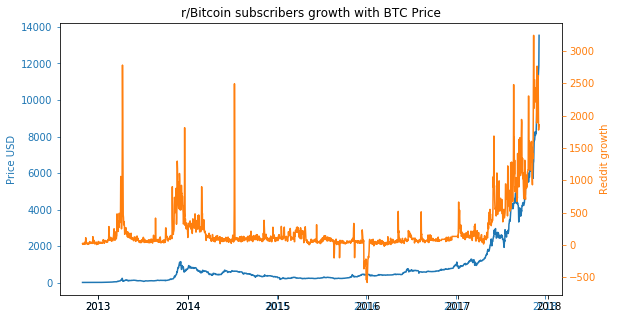

In [81]:
#plot the reddit subscribers growth versus the price growth
fig=plt.figure(figsize=(9,5))

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(df_target.index,df_target.values.astype(float), color="C0")
ax.set_ylabel("Price USD", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


ax2.plot(df_full.index ,df_full['redditors_growth'].astype(float) , color="C1")
ax2.yaxis.tick_right()
ax2.set_ylabel('Reddit growth', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")

plt.title('r/Bitcoin subscribers growth with BTC Price')
plt.show()

As we can see, spikes in reddit subscribers are definitely correlated with spikes in Bitcoin price. This is especially evident in 2014, and in the past 6 months especially.

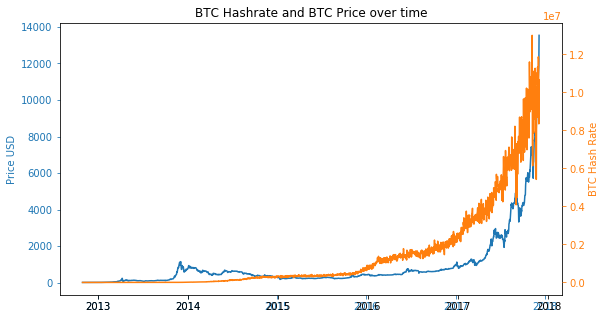

In [82]:
fig=plt.figure(figsize=(9,5))

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(df_target.index,df_target.values.astype(float), color="C0")
ax.set_ylabel("Price USD", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


ax2.plot(df_full.index ,df_full['BTC Hash Rate'].astype(float) , color="C1")
ax2.yaxis.tick_right()
ax2.set_ylabel('BTC Hash Rate', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")
plt.title('BTC Hashrate and BTC Price over time')
plt.show()

The BTC Hash rate indicates the difficulty of mining Bitcoin. Naturally, as mainstream acceptance further penetrates the Bitcoin market, more and more Bitcoins will be generated making it harder to mine, increasing the Hash rate.

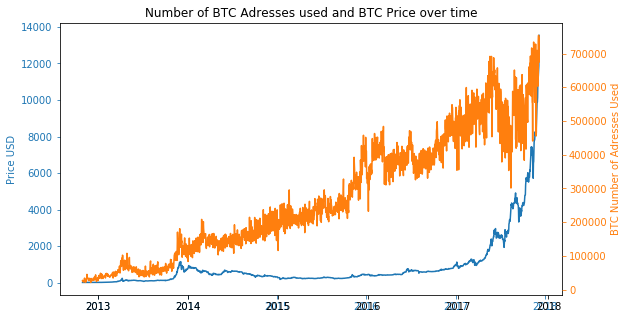

In [83]:
# Plot number of adresses used vs price
fig=plt.figure(figsize=(9,5))

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(df_target.index,df_target.values.astype(float), color="C0")
ax.set_ylabel("Price USD", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


ax2.plot(df_full.index ,df_full['BTC Number of Adresses Used'].astype(float) , color="C1")
ax2.yaxis.tick_right()
ax2.set_ylabel('BTC Number of Adresses Used', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")
plt.title('Number of BTC Adresses used and BTC Price over time')
plt.show()

It is obvious that the growth in users and devices used on the bitcoin network are closely related.

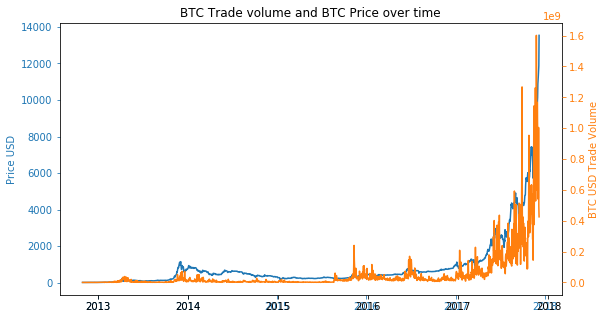

In [84]:
# Plot price vs trade volume
fig=plt.figure(figsize=(9,5))

ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(df_target.index,df_target.values.astype(float), color="C0")
ax.set_ylabel("Price USD", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")


ax2.plot(df_full.index ,df_full['BTC USD Trade Volume'].astype(float) , color="C1")
ax2.yaxis.tick_right()
ax2.set_ylabel('BTC USD Trade Volume', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="C1")
plt.title('BTC Trade volume and BTC Price over time')
plt.show()

As we can see, there is a positive relationship between the trade volume in USD for Bitcoin and the price of Bitcoin itself.

### II - B) Correlaton matrix

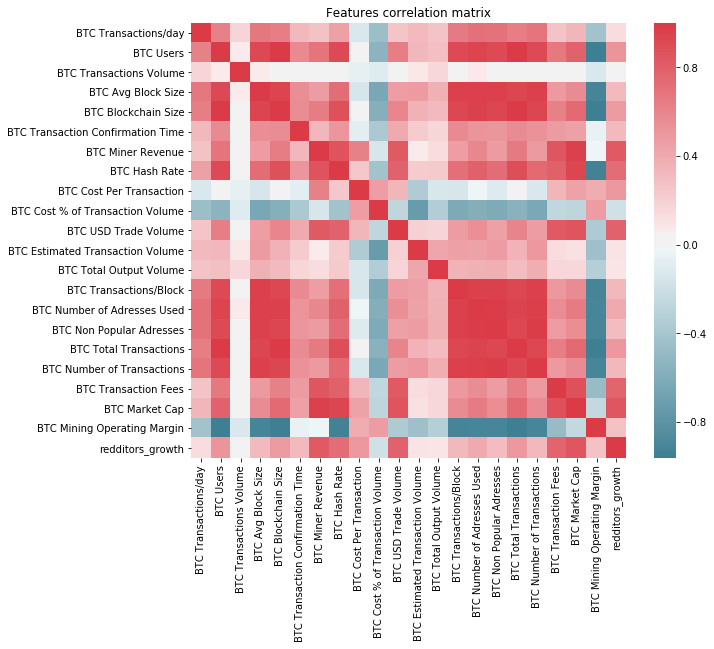

In [85]:
#plot the correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = df_full.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Features correlation matrix')
plt.show()

#### Note: 
During our modeling phase, we had planned out to remove the following variables as a means of feature selection - however, our models consistently performed more poorly with this form of feature selection regardless of how many cross validated models with hyperparameter tuning we performed. 
This can be due to the following reasons: <br>
a. These features are important and are correlated due to structure of Bitcoin expanding <br>
b. Our most performative models perform feature selection on their own (ridge regression and lasso regressions) and sift through all these features <br>

Features initially removed: <br>

1. Bitcoin Average Block Size: Average Blockchain size 
2. Bitcoin cost percentage on transaction volume: Proportion of Cost relative to total transaction volume 
3. Bitcoin USD trade volume: Total Volume in USD 
4. Bitcoin Estimated Transaction Volume: Estimated transaction volume 
5. Bitcoin Total Output Volume: Bitcoin Total Volume 
6. Bitcoin Transactions/Block: Number of transactions per block 
7. Bitcoin Non Popular Adresses: Non popular adresses 
8. Bitcoin Number of Transactions: Number of transactions on the chain 
9. Bitcoin Market Cap: Bitcoin Market Capitalization 
10. Bitcoin Mining Operating Margin: Operating margin of all miners 


### II - c) Import Dataset 

In [8]:
#after calling the API we then saved it in a dataset in order to avoid calling quandl each time 
#import dataset
df_features = pd.read_csv('df_features.csv', index_col = [0])
df_target = pd.read_csv('target.csv', index_col = [0])

In [9]:
#set dataset
df_target.index = pd.to_datetime(df_target.index)
df_features.index = pd.to_datetime(df_features.index)

## III - Stationarity Study

Stationarity constitutes an important part of time series forecasting, a stationary process has the property that the mean, variance and autocorrelation structure do not change over time. In the case of non-stationary processes where statistic properties change over time it becomes very difficult to predict movements in the time series using conventional technics. In this condition, it is always best to study stationary processes or to render the process stationary. 
Most economic time series are far from stationary even after some seasonality adjustments and obvious pre-processing. So, it has become common to look for long term trends and reverse it using mathematical transformations. Bitcoin price is no exception to this, it even follows an exponential trend, the price has risen 13 times in the course of 2017 and it only took 90 days to go from 4,000 USD to 8,000 USD. We can look at an example of stationarity below<br>

![Stationarity](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Stationarycomparison.png/390px-Stationarycomparison.png)

A common process to verify if a time series is stationary is to do a unit root test, which means try and find if the time series variable has a unit root, if there are none then the process is stationary else it is not. One of the most well-known and used test is the Augmented Dickey fuller test which tests the correlation between two successive observations in a time series and tries to determine the presence of a unit root in the autoregressive equation.

### III- a) Dickey-fuller test

In [95]:
#Augmented Dicked Fuller test to check for bitcoin price stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### III - a - 1) Is Bitcoin's price a stationary process?

We will perform the augmented dickey fuller test on Bitcoin's price to test whethet it's a stationary process or not. 

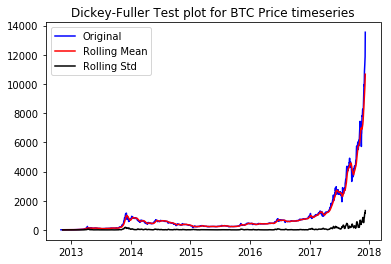

Results of Dickey-Fuller Test:
Test Statistic                    4.407588
p-value                           1.000000
#Lags Used                       25.000000
Number of Observations Used    1840.000000
Critical Value (1%)              -3.433909
Critical Value (5%)              -2.863112
Critical Value (10%)             -2.567607
dtype: float64


In [96]:
test_stationarity(df_target['Value'], 'Dickey-Fuller Test plot for BTC Price timeseries')

As we can see from the augmented dicky fuller test, the test statistic is over the critical values which confirms that Bitcoin' price time series is not stationary.

### III - a - 2) Is the price direction a stationary process?

Since is this is a bitcoin price direction classification problem - we will perform the augmented dickey fuller test on the price direction o the data. Keep in mind that price direction is whether the data is going up (1 for up) or down (0 for down)

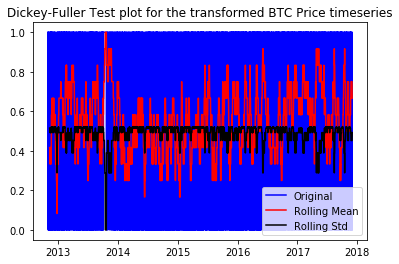

Results of Dickey-Fuller Test:
Test Statistic                -8.780066e+00
p-value                        2.390000e-14
#Lags Used                     1.300000e+01
Number of Observations Used    1.845000e+03
Critical Value (1%)           -3.433899e+00
Critical Value (5%)           -2.863108e+00
Critical Value (10%)          -2.567605e+00
dtype: float64


In [100]:
#test stationnarity of the 1,0 TS with a Dick-Fuller test
test_stationarity(df_target['Mkt_State'], 'Dickey-Fuller Test plot for the transformed BTC Price timeseries')

Test statitistic under the 1% critical value. The differenced time series is sure to be stationary. Thus, we can perform our prediction modelling on this data! 

### III - b) Trend and seasonality analysis of the price times series
Part of any time series forecasting is understanding the impact of trend and seasonality in the foreasting endeavor. As adjusting for trend and seasionality makes our prediction models better understand the data generation process. 

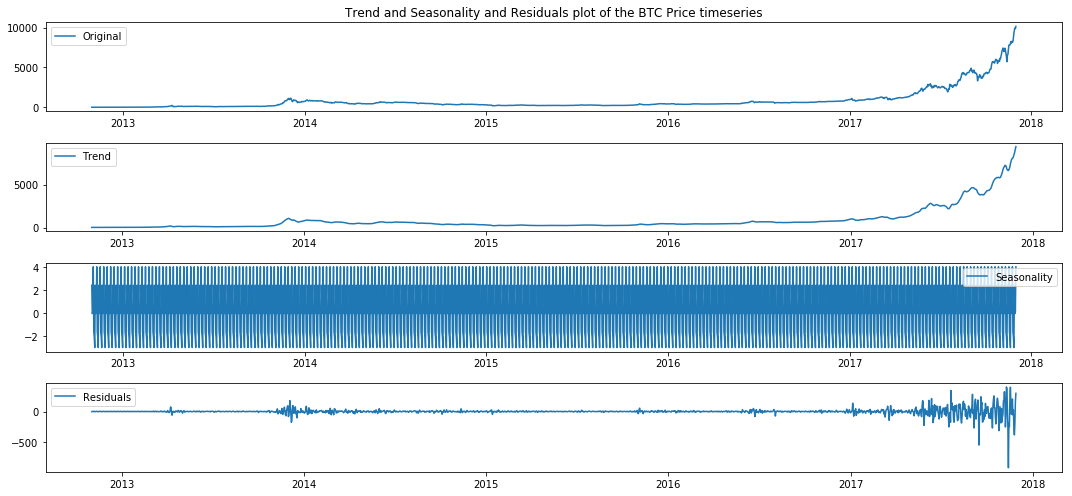

In [108]:
#Trend, seasonality and residual analysis
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_target['Price'])
fig1 = plt.figure(figsize = (15,7))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.title('Trend and Seasonality and Residuals plot of the BTC Price timeseries')
plt.plot(df_target['Price'] , label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Make the features stationary to avoid spurious regression problems

In [10]:
#make the features stationary as well !
for i in df_features.columns:
    stationaring(df_features, str(i))

## V) Setting our parameters

### V - a) Training & Testing sets parameters

In [11]:
#choose target value for the target vector
df_target = df_target['Mkt_State']

In [12]:
#define horizon of the test set in days
horizon = 10
#define depth of the traning set in days
depth = horizon + 300

In [13]:
#get the same index for target and features
target = set_index(df_features, df_target)

delta removed: 7


In [14]:
#set the working vectors
X_train, y_train, X_test, y_test = split_train_test(df_features, target,depth, horizon)

Training set: 2017-01-19 00:00:00 to 2017-11-14 00:00:00 ; Days:300
 Testing set: 2017-11-15 00:00:00 to 2017-11-24 00:00:00 ; Days:10


### V - b) Cross Validation settings

Our time series cross validation technique consisted of a rolling basis cross validation. We used a three hundred day training set with a 20 day cross validation window, with final scores being predicted on a 10 day test set*(the choice of training set was due to the structural changes Bitcoin has endured in the past year, whereas the choice of test set was shrunk in order to control for accuracy in a time series forecast.)*  
In this procedure, the training set consists of observations that occured prior to the cross validation set, the cross validation accuracy is computed by averaging over all forecasts, and then the final prediction accuracy is computer on the test set. An illustration of this technique can be found below
![Cross Validation](cv1-1.png)

In [15]:
## Cross validation hyperparameters
#define the CV set horizon
horizon_cv = 20
#define the CV_training set depth
depth_cv = len(X_train)
#define number of features to combine (used for some models)
features = features_combin(15)
# feature combination : #/!\ HAS TO BE SET ON 0 if the model takes all the features
c = 0

In [16]:
#X_cv_train, y_cv_train, X_cv_test, y_cv_test = #set the working vectors
X_cv_train, y_cv_train, X_cv_test, y_cv_test = split_train_test(X_train, y_train,depth_cv, horizon_cv)

Training set: 2017-01-19 00:00:00 to 2017-10-25 00:00:00 ; Days:280
 Testing set: 2017-10-26 00:00:00 to 2017-11-14 00:00:00 ; Days:20


In [17]:
### check the score of the null model
print('CV Null model score:', y_cv_test.mean())

CV Null model score: 0.6


## VI - Prediction modeling

### VI - a) Logistic Regression

#### VI - a - 1) Lasso Logistic Regresion

##### Cross Validation

Since it is difficult to perform cross validated grid search on time series data, we developed a custom grid search function that works well for lasso and ridge logitsic regressions. It performs a one step ahead prediction based on the rolling cross validation function we discussed earlier 
The parameters to tune for the logistic regression are: 
 - C (inverse of regularization strength)
 - Weights attributed to different classes (0 or 1) <br>
 
It is worth noticing that there is no need to do features selection since the L1 & L2 regularization will set some coefficients 
to 0 by itself. 

In [18]:
#initialize a dictionnary in order to store the score of the differents parameters
scores = {}

#loop over the different parameters possiblities
for i in range(1,11,1):
    for j in range(1,11,1):
        for k in range(1,11,1):
            
            #store the hyperparameters combination
            triple = str([i,j,k])

            #call the logistic regression
            log_l1 = LogisticRegression(penalty='l1', 
                                     C=i/10, 
                                     class_weight = {0: j/10, 1: k/10}, 
                                     random_state=0, 
                                     solver='saga', 
                                     max_iter=500, 
                                     verbose=0)
            
            #call the rolling prediction function on the CV set
            y_predict = rolling_prediction(log_l1, X_cv_train, y_cv_train, X_cv_test, y_cv_test, verbose = 0)
            
            #compute the score on the cv
            score = accuracy_score(y_cv_test.values, y_predict)
            
            #store the score as the values of the triple key
            scores[triple] = score
            
            #print(triple, score)
            
 #sort dictionnary by occurence order to find the best scores
scores_sort = sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [237]:
#initialize a dictionnary in order to store the score of the differents parameters
scores = {}

#loop over the different parameters possiblities
for i in range(1,11,1):
    for j in range(1,11,1):
        for k in range(1,11,1):
            
            #store the hyperparameters combination
            triple = str([i,j,k])

            #call the logistic regression
            log_l1 = LogisticRegression(penalty='l1', 
                                     C=i/10, 
                                     class_weight = {0: j/10, 1: k/10}, 
                                     random_state=0, 
                                     solver='saga', 
                                     max_iter=500, 
                                     verbose=0)
            
            #call the rolling prediction function on the CV set
            y_predict = rolling_prediction(log_l1, X_cv_train, y_cv_train, X_cv_test, y_cv_test, verbose = 0)
            
            #compute the score on the cv
            score = accuracy_score(y_cv_test.values, y_predict)
            
            #store the score as the values of the triple key
            scores[triple] = score
            
            #print(triple, score)
            
 #sort dictionnary by occurence order to find the best scores
scores_sort = sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [19]:
#print best model with its score on the CV set, the L1-logistic
print(scores_sort[0])

('[4, 10, 6]', 0.69999999999999996)


In [20]:
#print the top best scores on the CV model
scores_sort[:8]

[('[4, 10, 6]', 0.69999999999999996),
 ('[7, 5, 3]', 0.69999999999999996),
 ('[8, 5, 3]', 0.69999999999999996),
 ('[3, 8, 5]', 0.65000000000000002),
 ('[3, 10, 6]', 0.65000000000000002),
 ('[4, 5, 3]', 0.65000000000000002),
 ('[4, 9, 6]', 0.65000000000000002),
 ('[5, 5, 3]', 0.65000000000000002)]

There are some hyperparameters combinations which overperforms the null model (7 in total !). 
Let's try them now on the test set !

##### Test of the best Cross-Validated model

In [113]:
#call the models with the best 3-hyperparameters:
log_l1 = LogisticRegression(penalty='l1', 
                                     C=0.9, 
                                     class_weight = {0: 1, 1: 0.6}, 
                                     random_state=0, 
                                     solver='saga', 
                                     max_iter=500, 
                                     verbose=0)

In [114]:
#test the model on the final test set
y_predict = rolling_prediction(log_l1, X_train, y_train, X_test, y_test, verbose = 1)

Prediction n°: 1 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 2 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 3 ; test_value: [0]
value predicted: [0] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 4 ; test_value: [1]
value predicted: [0] ; accurate: [False]
--------------------------------------------------------------------------------
Prediction n°: 5 ; test_value: [1]
value predicted: [0] ; accurate: [False]
--------------------------------------------------------------------------------
Prediction n°: 6 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 7 ; test_value: [0]
value predicted: [0] ; 

##### Classification report for Rolling L1 :

In [115]:
#Classification report for the non CV L1 score
target_names = ['class 0', 'class 1']
print(classification_report(y_test.values, y_predict, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.60      1.00      0.75         3
    class 1       1.00      0.71      0.83         7

avg / total       0.88      0.80      0.81        10



In [116]:
#print the score of the last rolling prediction
score = accuracy_score(y_test.values, y_predict)
print('L1 best CV Logistic Regression score: ', score)

L1 best CV Logistic Regression score:  0.8


This L1 Logistic Regression (C=0.9, 0_weights = 1, 1_weight = 0.6) scores an impressive 0.8 on the test set, which is way better than the null model (which would have consisted in predicting always 1 on the 10 days test) ! 

#### VI - a - 2) Ridge Logistic Regresion

##### Cross Validation
The Ridge Logistic Regression overperforms the null model on the CV set with a score of 0.65. 
However, it converges to the null model on the test set with a score of 0.7. 

In [27]:
#initialize a dictionnary in order to store the score of the differents parameters
scores = {}

#loop over the different parameters possiblities

for j in range(1000):
    for i in range(1,11,1):
        
        c = j

        #store the hyperparameters combination
        duble = str([i,j])

        #call the logistic regression
        log_l2 = LogisticRegression(penalty='l2', 
                                 C=i/10, 
                                 random_state=0, 
                                 solver='liblinear', 
                                 max_iter=400, 
                                 verbose=0)

        #call the rolling prediction function on the CV set
        y_predict = rolling_prediction(log_l2, X_cv_train, y_cv_train, X_cv_test, y_cv_test, verbose = 0)

        #compute the score on the cv
        score = accuracy_score(y_cv_test.values, y_predict)

        #store the score as the values of the triple key
        scores[duble] = score

 #sort dictionnary by occurence order to find the best scores
scores_sort = sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [28]:
print(scores_sort[0])

('[4, 18]', 0.65000000000000002)


##### Test of the best Cross-Validated model

In [29]:
#define number of features to combine 
features = features_combin(14)
# feature combination :
c = 18

#call the model with the best 3-hyperparameters:
log_l2 = LogisticRegression(penalty='l2', 
                         C=0.4, 
                         random_state=0, 
                         solver='liblinear', 
                         max_iter=300, 
                         verbose=0)

In [30]:
#test the model on the final test set
y_predict = rolling_prediction(log_l2, X_train, y_train, X_test, y_test, verbose = 1)

Prediction n°: 1 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 2 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 3 ; test_value: [0]
value predicted: [1] ; accurate: [False]
--------------------------------------------------------------------------------
Prediction n°: 4 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 5 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 6 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 7 ; test_value: [0]
value predicted: [1] ; 

In [31]:
#Classification report for the best CV random forest
target_names = ['class 0', 'class 1']
print(classification_report(y_test.values, y_predict, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.00      0.00      0.00         3
    class 1       0.70      1.00      0.82         7

avg / total       0.49      0.70      0.58        10



Excalty the same conclusions as the L1-Logistic

### VI - b) Random Forest

We implemented here a Rolling Random Forest. We only played on the 'max_features' hyperparameters and noticed a Cross Validation 
score much better when it was equal to 8. The CV set is slightly hiher than the score of the null model (0.65).
However, like the Ridge Regression, the model tends to converge to the null model on the test score by predicting always 1.

### Cross Validation

In [245]:
## Cross validation hyperparameters
#define the CV set horizon
horizon = 10
#define the CV_training set depth
depth = 300 + horizon
#define number of features to combine (used for some models)
features = features_combin(21)
#feature combination
c = 0

In [246]:
#set the working vectors for CV
X_train, y_train, X_test, y_test = split_train_test(df_features, target,depth, horizon)

Training set: 2017-01-19 00:00:00 to 2017-11-14 00:00:00 ; Days:300
 Testing set: 2017-11-15 00:00:00 to 2017-11-24 00:00:00 ; Days:10


In [241]:
## Cross validation hyperparameters
#define the CV set horizon
horizon = 20
#define the CV_training set depth
depth = 300
#define number of features to combine (used for some models)
features = features_combin(21)
#feature combination
c = 0

In [242]:
#initialize a dictionnary in order to store the score of the differents parameters
scores = {}

for i in range(8, 14):
    
    #set the working vectors
    X_train, y_train, X_test, y_test = split_train_test(df_features, target,depth, horizon, verbose = False)
       
    #set the working vectors for CV
    X_cv_train, y_cv_train, X_cv_test, y_cv_test = split_train_test(X_train,y_train,depth_cv, horizon_cv, verbose = False)
    
    #call the l2-logistic regression
    Rf = RandomForestClassifier(n_estimators=100, 
                           criterion="entropy", 
                           max_depth=5,
                           max_features=i, 
                           min_samples_split=4, 
                           max_leaf_nodes = 10,
                           random_state=0)
    
    #set the test and training set to the right features
    y_predict = rolling_prediction(Rf, X_train, y_train, X_test, y_test, verbose = 0)

    #compute the score on the cv
    score = accuracy_score(y_cv_test.values, y_predict)

    #store the score as the values of the triple key
    scores[i] = score

    #print(triple, score)
            
 #sort dictionnary by occurence order to find the best scores
scores_sort = sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [243]:
print(scores_sort[0])

(8, 0.65000000000000002)


#### Test of the best CV Random Forest models

In [247]:
#set the working vectors
X_train, y_train, X_test, y_test = split_train_test(df_features, target,depth, horizon, verbose = True)

#call the l2-logistic regression
Rf = RandomForestClassifier(n_estimators=100, 
                       criterion="entropy", 
                       max_depth=5,
                       max_features=8, 
                       min_samples_split=8, 
                       max_leaf_nodes = 10,
                       random_state=0)

#set the test and training set to the right features
y_predict = rolling_prediction(Rf, X_train, y_train, X_test, y_test, verbose = 1)

#compute the score on the cv
score = accuracy_score(y_test.values, y_predict)

Training set: 2017-01-19 00:00:00 to 2017-11-14 00:00:00 ; Days:300
 Testing set: 2017-11-15 00:00:00 to 2017-11-24 00:00:00 ; Days:10
Prediction n°: 1 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 2 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 3 ; test_value: [0]
value predicted: [1] ; accurate: [False]
--------------------------------------------------------------------------------
Prediction n°: 4 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 5 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 6 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
----

#### Classification report for the best CV random forest

In [248]:
#Classification report for the best CV random forest
target_names = ['class 0', 'class 1']
print(classification_report(y_test.values, y_predict, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.00      0.00      0.00         3
    class 1       0.70      1.00      0.82         7

avg / total       0.49      0.70      0.58        10



In [144]:
#print the test score of the best CV Randome Forest
print('Best CV Random Forest Model test score: ', score)

Best CV Random Forest Model test score:  0.7


### VI - c) LSTM

In [ ]:
Unfortunately, we were not able to have good results with the LSTM since the test score we manage to achieve is 0.4

In [145]:
#Dataset parameters
#define the CV set horizon
horizon = 10
#define the CV_training set depth
depth = 500

In [146]:
#set the working vectors
X_train, y_train, X_test, y_test = split_train_test(df_features,target,depth, horizon, verbose = True)

Training set: 2016-07-13 00:00:00 to 2017-11-14 00:00:00 ; Days:490
 Testing set: 2017-11-15 00:00:00 to 2017-11-24 00:00:00 ; Days:10


In [147]:
# How to reshape data for LSTM
training = X_train.values.reshape((X_train.shape[0],1, X_train.shape[1]))
testing = X_test.values.reshape((X_test.shape[0],1, X_test.shape[1]))

In [148]:
# How to LSTM?
n_features = X_train.shape[1]
n_samples  = X_train.shape[0]
timesteps = 1
model = Sequential()
model.add(LSTM(n_samples, input_shape = (timesteps,n_features)))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [149]:
model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics = ["accuracy"])

In [150]:
history = model.fit(training, y_train.values, epochs = 500, batch_size = len(training), verbose = 2)

Epoch 1/500
 - 2s - loss: 0.6954 - acc: 0.4429
Epoch 2/500
 - 0s - loss: 0.6859 - acc: 0.5939
Epoch 3/500
 - 0s - loss: 0.6788 - acc: 0.6020
Epoch 4/500
 - 0s - loss: 0.6740 - acc: 0.6020
Epoch 5/500
 - 0s - loss: 0.6714 - acc: 0.6020
Epoch 6/500
 - 0s - loss: 0.6707 - acc: 0.6020
Epoch 7/500
 - 0s - loss: 0.6713 - acc: 0.6020
Epoch 8/500
 - 0s - loss: 0.6723 - acc: 0.6020
Epoch 9/500
 - 0s - loss: 0.6732 - acc: 0.6020
Epoch 10/500
 - 0s - loss: 0.6736 - acc: 0.6020
Epoch 11/500
 - 0s - loss: 0.6733 - acc: 0.6020
Epoch 12/500
 - 0s - loss: 0.6726 - acc: 0.6020
Epoch 13/500
 - 0s - loss: 0.6716 - acc: 0.6020
Epoch 14/500
 - 0s - loss: 0.6705 - acc: 0.6020
Epoch 15/500
 - 0s - loss: 0.6695 - acc: 0.6020
Epoch 16/500
 - 0s - loss: 0.6687 - acc: 0.6020
Epoch 17/500
 - 0s - loss: 0.6682 - acc: 0.6020
Epoch 18/500
 - 0s - loss: 0.6679 - acc: 0.6020
Epoch 19/500
 - 0s - loss: 0.6677 - acc: 0.6020
Epoch 20/500
 - 0s - loss: 0.6677 - acc: 0.6020
Epoch 21/500
 - 0s - loss: 0.6677 - acc: 0.6020
E

Epoch 171/500
 - 0s - loss: 0.6163 - acc: 0.6694
Epoch 172/500
 - 0s - loss: 0.6152 - acc: 0.6694
Epoch 173/500
 - 0s - loss: 0.6141 - acc: 0.6755
Epoch 174/500
 - 0s - loss: 0.6130 - acc: 0.6755
Epoch 175/500
 - 0s - loss: 0.6118 - acc: 0.6755
Epoch 176/500
 - 0s - loss: 0.6107 - acc: 0.6776
Epoch 177/500
 - 0s - loss: 0.6095 - acc: 0.6796
Epoch 178/500
 - 0s - loss: 0.6083 - acc: 0.6796
Epoch 179/500
 - 0s - loss: 0.6071 - acc: 0.6796
Epoch 180/500
 - 0s - loss: 0.6059 - acc: 0.6837
Epoch 181/500
 - 0s - loss: 0.6046 - acc: 0.6857
Epoch 182/500
 - 0s - loss: 0.6034 - acc: 0.6857
Epoch 183/500
 - 0s - loss: 0.6021 - acc: 0.6878
Epoch 184/500
 - 0s - loss: 0.6009 - acc: 0.6857
Epoch 185/500
 - 0s - loss: 0.5996 - acc: 0.6857
Epoch 186/500
 - 0s - loss: 0.5983 - acc: 0.6857
Epoch 187/500
 - 0s - loss: 0.5970 - acc: 0.6878
Epoch 188/500
 - 0s - loss: 0.5957 - acc: 0.6959
Epoch 189/500
 - 0s - loss: 0.5944 - acc: 0.6939
Epoch 190/500
 - 0s - loss: 0.5931 - acc: 0.6980
Epoch 191/500
 - 0s 

 - 0s - loss: 0.3718 - acc: 0.8531
Epoch 339/500
 - 0s - loss: 0.3704 - acc: 0.8571
Epoch 340/500
 - 0s - loss: 0.3689 - acc: 0.8551
Epoch 341/500
 - 0s - loss: 0.3675 - acc: 0.8592
Epoch 342/500
 - 0s - loss: 0.3660 - acc: 0.8571
Epoch 343/500
 - 0s - loss: 0.3646 - acc: 0.8592
Epoch 344/500
 - 0s - loss: 0.3631 - acc: 0.8592
Epoch 345/500
 - 0s - loss: 0.3616 - acc: 0.8592
Epoch 346/500
 - 0s - loss: 0.3602 - acc: 0.8592
Epoch 347/500
 - 0s - loss: 0.3587 - acc: 0.8592
Epoch 348/500
 - 0s - loss: 0.3572 - acc: 0.8592
Epoch 349/500
 - 0s - loss: 0.3558 - acc: 0.8633
Epoch 350/500
 - 0s - loss: 0.3543 - acc: 0.8673
Epoch 351/500
 - 0s - loss: 0.3529 - acc: 0.8714
Epoch 352/500
 - 0s - loss: 0.3514 - acc: 0.8714
Epoch 353/500
 - 0s - loss: 0.3500 - acc: 0.8714
Epoch 354/500
 - 0s - loss: 0.3486 - acc: 0.8755
Epoch 355/500
 - 0s - loss: 0.3472 - acc: 0.8714
Epoch 356/500
 - 0s - loss: 0.3458 - acc: 0.8755
Epoch 357/500
 - 0s - loss: 0.3446 - acc: 0.8714
Epoch 358/500
 - 0s - loss: 0.3434

In [151]:
loss = model.evaluate(training, y_train.values, verbose = 1)
print(loss)

490/490 [==============================] - 0s 471us/step
[0.19053019899494794, 0.95102040767669682]


In [152]:
predictions = model.predict(testing, verbose = 2)

In [153]:
preds = predictions.round()

In [154]:
accuracy_score(preds,y_test)

0.40000000000000002

#### Classification report for the LSTM

In [155]:
#Classification report for the LSTM
target_names = ['class 0', 'class 1']
print(classification_report(preds,y_test, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.00      0.00      0.00         3
    class 1       0.57      0.57      0.57         7

avg / total       0.40      0.40      0.40        10



## VII - Reduction of training set

Bitcoin has encountered fundemental changes in the last year, months and even weeks. As prices have jumped thousands of dollars in the matter of weeks. Thus, we wanted to experiment with reducing the training set in order to to try to capture the different phases of Bitcoin. We decided to leverage the past 70 days of Bitcoin in order to try to improve accuracy

### VII - a) Cross Validated Rolling L1 Regression:

In [249]:
## Cross validation hyperparameters
#define the CV set horizon
horizon_cv = 20
#define the CV_training set depth
depth_cv = 70
#define number of features to combine (used for some models)
features = features_combin(14)
# feature combination : #/!\ HAS TO BE SET ON 0 if the model takes all the features
c = 0

In [250]:
#X_cv_train, y_cv_train, X_cv_test, y_cv_test = #set the working vectors
X_cv_train, y_cv_train, X_cv_test, y_cv_test = split_train_test(X_train, y_train,depth_cv, horizon_cv)

Training set: 2017-09-06 00:00:00 to 2017-10-25 00:00:00 ; Days:50
 Testing set: 2017-10-26 00:00:00 to 2017-11-14 00:00:00 ; Days:20


In [251]:
#initialize a dictionnary in order to store the score of the differents parameters
scores = {}

#loop over the different parameters possiblities
for i in range(1,11,1):
    for j in range(1,11,1):
        for k in range(1,11,1):
            
            #store the hyperparameters combination
            triple = str([i,j,k])

            #call the logistic regression
            log_l1 = LogisticRegression(penalty='l1', 
                                     C=i/10, 
                                     class_weight = {0: j/10, 1: k/10}, 
                                     random_state=0, 
                                     solver='saga', 
                                     max_iter=300, 
                                     verbose=0)
            
            #call the rolling prediction function on the CV set
            y_predict = rolling_prediction(log_l1, X_cv_train, y_cv_train, X_cv_test, y_cv_test, verbose = 0)
            
            #compute the score on the cv
            score = accuracy_score(y_cv_test.values, y_predict)
            
            #store the score as the values of the triple key
            scores[triple] = score
            
            #print(triple, score)
            
 #sort dictionnary by occurence order to find the best scores
scores_sort = sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [168]:
#print best model with its score on the CV set, the L1-logistic
print(scores_sort[:5])

[('[1, 9, 8]', 0.65000000000000002), ('[1, 10, 9]', 0.65000000000000002), ('[1, 1, 2]', 0.59999999999999998), ('[1, 1, 3]', 0.59999999999999998), ('[1, 1, 4]', 0.59999999999999998)]


The L1 CV Log Regression on 50 days training set is here overperforming the null model. Let's try it on the test set

In [169]:
#call the model with the best 3-hyperparameters:
log_l1 = LogisticRegression(penalty='l1', 
                                     C=1, 
                                     class_weight = {0: 1, 1: 0.9}, 
                                     random_state=0, 
                                     solver='saga', 
                                     max_iter=500, 
                                     verbose=0)

In [170]:
#test the model on the final test set
y_predict = rolling_prediction(log_l1, X_train, y_train, X_test, y_test, verbose = 1)

Prediction n°: 1 ; test_value: [1]
value predicted: [0] ; accurate: [False]
--------------------------------------------------------------------------------
Prediction n°: 2 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 3 ; test_value: [0]
value predicted: [1] ; accurate: [False]
--------------------------------------------------------------------------------
Prediction n°: 4 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 5 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 6 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 7 ; test_value: [0]
value predicted: [1] ; 

In [171]:
#Classification report for the non CV L1 score
target_names = ['class 0', 'class 1']
print(classification_report(y_test.values, y_predict, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.00      0.00      0.00         3
    class 1       0.67      0.86      0.75         7

avg / total       0.47      0.60      0.53        10



In [172]:
#print the score of the last rolling prediction
score = accuracy_score(y_test.values, y_predict)
print('L1 best CV Logistic Regression score (70 days training set): ', score)

L1 best CV Logistic Regression score (70 days training set):  0.6


### VII - b) Cross Validated Rolling Random Forest with 70 days training set

In [180]:
## Cross validation hyperparameters
#define the CV set horizon
horizon = 10
#define the CV_training set depth
depth = 70 + horizon
#define number of features to combine (used for some models)
features = features_combin(21)
#feature combination
c = 0

In [174]:
#set the working vectors for CV
X_train, y_train, X_test, y_test = split_train_test(df_features, target,depth, horizon)

Training set: 2017-09-06 00:00:00 to 2017-11-14 00:00:00 ; Days:70
 Testing set: 2017-11-15 00:00:00 to 2017-11-24 00:00:00 ; Days:10


In [179]:
## Cross validation hyperparameters
#define the CV set horizon
horizon = 20
#define the CV_training set depth
depth = 70
#define number of features to combine (used for some models)
features = features_combin(21)
#feature combination
c = 0

In [176]:
#initialize a dictionnary in order to store the score of the differents parameters
scores = {}

for i in range(8, 14):
    
    #set the working vectors
    X_train, y_train, X_test, y_test = split_train_test(df_features, target,depth, horizon, verbose = False)
       
    #set the working vectors for CV
    X_cv_train, y_cv_train, X_cv_test, y_cv_test = split_train_test(X_train,y_train,depth_cv, horizon_cv, verbose = False)
    
    #call the l2-logistic regression
    Rf = RandomForestClassifier(n_estimators=100, 
                           criterion="entropy", 
                           max_depth=5,
                           max_features=i, 
                           min_samples_split=4, 
                           max_leaf_nodes = 10,
                           random_state=0)
    
    #set the test and training set to the right features
    y_predict = rolling_prediction(Rf, X_train, y_train, X_test, y_test, verbose = 0)

    #compute the score on the cv
    score = accuracy_score(y_cv_test.values, y_predict)

    #store the score as the values of the triple key
    scores[i] = score

    #print(triple, score)
            
 #sort dictionnary by occurence order to find the best scores
scores_sort = sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [177]:
print(scores_sort[0])

(9, 0.59999999999999998)


Here again, the Rolling random forest trained over 70 days outperforms the null model on the CV set. 
Let's try it on the test set !

In [181]:
#set the working vectors
X_train, y_train, X_test, y_test = split_train_test(df_features, target,depth, horizon, verbose = True)

#call the l2-logistic regression
Rf = RandomForestClassifier(n_estimators=100, 
                       criterion="entropy", 
                       max_depth=5,
                       max_features=9, 
                       min_samples_split=4, 
                       max_leaf_nodes = 10,
                       random_state=0)

#set the test and training set to the right features
y_predict = rolling_prediction(Rf, X_train, y_train, X_test, y_test, verbose = 1)

#compute the score on the cv
score = accuracy_score(y_test.values, y_predict)

Training set: 2017-09-06 00:00:00 to 2017-11-14 00:00:00 ; Days:70
 Testing set: 2017-11-15 00:00:00 to 2017-11-24 00:00:00 ; Days:10
Prediction n°: 1 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 2 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 3 ; test_value: [0]
value predicted: [1] ; accurate: [False]
--------------------------------------------------------------------------------
Prediction n°: 4 ; test_value: [1]
value predicted: [0] ; accurate: [False]
--------------------------------------------------------------------------------
Prediction n°: 5 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
--------------------------------------------------------------------------------
Prediction n°: 6 ; test_value: [1]
value predicted: [1] ; accurate: [ True]
-----

In [182]:
#Classification report for the best CV random forest
target_names = ['class 0', 'class 1']
print(classification_report(y_test.values, y_predict, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.00      0.00      0.00         3
    class 1       0.67      0.86      0.75         7

avg / total       0.47      0.60      0.53        10



In [183]:
#print the test score of the best CV Randome Forest
print('Best CV Random Forest Model test score: ', score)

Best CV Random Forest Model test score:  0.6


Finally, reducing the training set to 70 days led us to poorer results, whether it is with the Random Forest or with the Lasso.

## VIII - Final scores

### VIII - a) Cross Validation scores depending on models

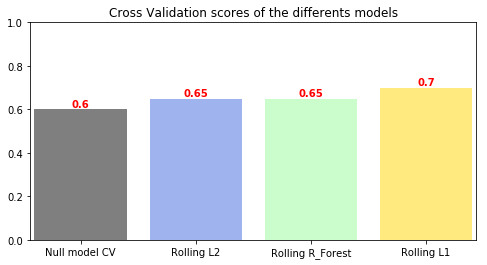

In [223]:
#plot the CV scores
x, height = np.arange(4),[0.6, 0.65, 0.65, 0.7]
colors = ['black', 'royalblue', 'palegreen', 'gold']

fig, ax = plt.subplots(figsize = (8,4))
ax.bar(x, height, alpha=0.5, color=colors)
ax.margins(0.01)
plt.xticks(x, ('Null model CV', 'Rolling L2', 'Rolling R_Forest', 'Rolling L1'))
plt.title('Cross Validation scores of the differents models')
ax.set_ylim([0,1])
for i, v in enumerate(height):
    ax.text(i, v+0.01, str(v), color='red', fontweight='bold', horizontalalignment ='center')
plt.show()

It is important ot note, that the rolling random forest for 70 days had the highest cross validation score out of all our models and training sets. 

### VIII - b) Test scores depending on models

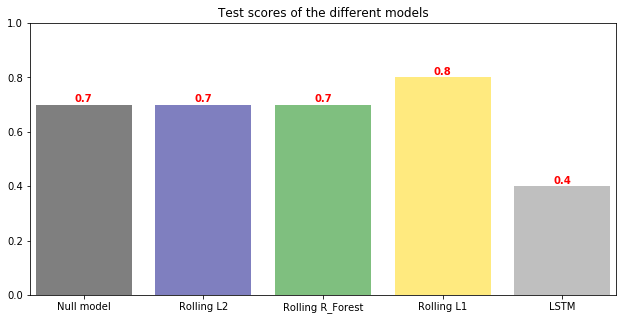

In [224]:
#plot the TEST scores
x, height = np.arange(5),[0.7, 0.7, 0.7, 0.8, 0.4]
colors = ['black', 'navy', 'green','gold', 'grey', ]

fig, ax = plt.subplots(figsize = (10.5,5))
ax.bar(x, height, alpha=0.5, color=colors)
ax.margins(0.01)
plt.xticks(x, ('Null model','Rolling L2', 'Rolling R_Forest','Rolling L1',  'LSTM' ))
plt.title('Test scores of the different models')
ax.set_ylim([0,1])
for i, v in enumerate(height):
    ax.text(i, v+0.01, str(v), color='red', fontweight='bold', horizontalalignment ='center')
plt.show()

Ultimately, there was no difference between the size of the trianing set, if anything decreasing it led to a smaller accuracy on some models, but with higher cross validation on others. 